Importing Libraries

In [41]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (/Users/dukeyi/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py)

Load Data

In [7]:
file_path = "/Users/dukeyi/Desktop/cleaned_data.csv"
df = pd.read_csv(file_path)

Define Features and Target Variables

In [8]:
# Define Features (X) and Target (y)
X = df.drop(columns=['PCOS (Y/N)'])  # Drop target column
y = df['PCOS (Y/N)']  # Target variable (1 = PCOS, 0 = No PCOS)

Feature Scaling (Normalization)

In [9]:
# Normalize Data for Better Training
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Feature Selection: Recursive Feature Elimination (RFE)

In [10]:
xgb_estimator = XGBClassifier(n_estimators=50, learning_rate=0.05, max_depth=3, eval_metric="logloss")
rfe = RFE(estimator=xgb_estimator, n_features_to_select=15)
X_selected = rfe.fit_transform(X_scaled, y)
selected_features = X.columns[rfe.support_]
display(selected_features)

Index(['BMI', 'Menstrual Cycle Length(days)', 'FSH/LH', 'AMH(ng/mL)',
       'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
       'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)',
       'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)',
       'Avg. F size (R) (mm)', 'Menstrual Cycle(R/I)_irregular'],
      dtype='object')

Train-Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

Apply SMOTE for Oversampling

In [40]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


NameError: name 'SMOTE' is not defined

Train Initial XGBoost Model

In [12]:
xgb_model = XGBClassifier(n_estimators=50, learning_rate=0.05, max_depth=3, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Hyperparameter

In [26]:
param_grid = {
    'n_estimators': [50, 100, 150],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 5, 7],  
    'subsample': [0.7, 0.8, 1.0],  
    'colsample_bytree': [0.7, 0.8, 1.0]  
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
print("Best Cross-Validation ROC AUC:", grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}
Best Cross-Validation ROC AUC: 0.9570303472602323


Train XGBoost Model with Best Hyperparameters

In [27]:
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Predictions

In [36]:
y_pred = best_xgb_model.predict(X_test)
y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

Model Evaluation

In [37]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

classification_rep = classification_report(y_test, y_pred)

display(pd.DataFrame({"Metric": ["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"],
                      "Score": [accuracy, precision, recall, f1, roc_auc]}))
print("\nClassification Report:\n", classification_rep)

,Metric,Score
0,Accuracy,0.878505
1,Precision,0.843750
2,Recall,0.771429
3,F1-score,0.805970
4,ROC AUC,0.931746



Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91        72
           1       0.84      0.77      0.81        35

    accuracy                           0.88       107
   macro avg       0.87      0.85      0.86       107
weighted avg       0.88      0.88      0.88       107



Plot ROC Curve

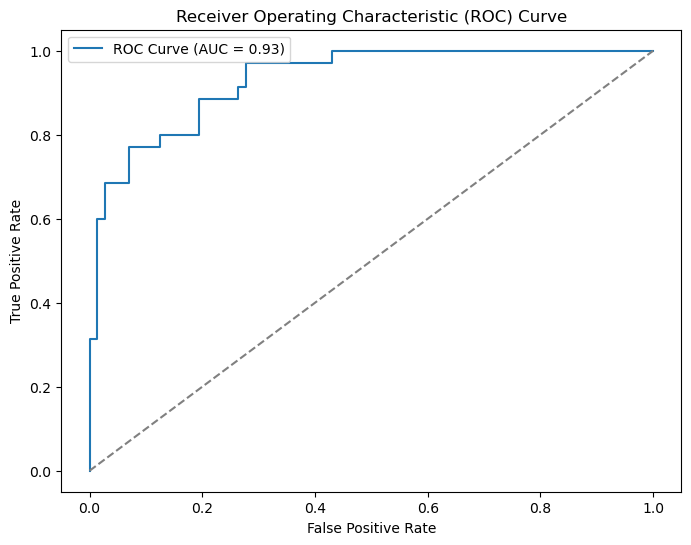

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Display Selected Features

In [39]:
print("Selected Features:", list(selected_features))

Selected Features: ['BMI', 'Menstrual Cycle Length(days)', 'FSH/LH', 'AMH(ng/mL)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Menstrual Cycle(R/I)_irregular']
